# Курсовой проект для курса "Python для Data Science"

#### Подключение библиотек и скриптов

In [305]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

### Функции

In [306]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [307]:
def converting_bin(df):
    df_str_value=df.select_dtypes(include='object')
    df[df_str_value.columns+'_bin']=(df[df_str_value.columns]=='A').astype('int64')

#### Пути к директориям и файлам

In [308]:
DATASET = 'train.csv'
DATASET_TEST = 'test.csv'

### Загрузка данных

#### Описание датасета:
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [309]:
df=pd.read_csv(DATASET)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [310]:
df.shape

(10000, 20)

## Анализ Датасета

### Типы данных

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


### Обзор количественных переменных

In [312]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


максимальные значения явно не корректны

### Обзор незаполненых значений

In [313]:
len(df)-df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

признак Healthcare_1  имеет 4798 не заполненых значений, для модели учитываться не будет. LifeSquare 2113 дозаполним медианным значением.

### Обзор номинативных переменных

In [314]:
df_str_value=df.select_dtypes(include='object')
df_str_value.head(3)

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B


In [315]:
print('Ecology_2'+"\n",df['Ecology_2'].value_counts())
print("-"*10)
print('Ecology_3'+"\n",df['Ecology_3'].value_counts())
print("-"*10)
print('Shops_2'+"\n",df['Shops_2'].value_counts())

Ecology_2
 B    9903
A      97
Name: Ecology_2, dtype: int64
----------
Ecology_3
 B    9725
A     275
Name: Ecology_3, dtype: int64
----------
Shops_2
 B    9175
A     825
Name: Shops_2, dtype: int64


данные признаки имеют два вида A, B. применим бинарное преобразование A=0, B=1

### Проверка корректности, корректировка данных

In [316]:
df[df['Rooms']>9]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


значение Rooms для данных приведем к значению медианному значению

In [317]:
df.loc[df['Rooms']>9,'Rooms']=df['Rooms'].median()

LifeSquare имеет пустые значения дозаполним медианным значением

In [318]:
df.loc[df['LifeSquare'].isnull(),'LifeSquare']=df['LifeSquare'].median()

In [319]:
df[df['Square']<(df['LifeSquare']+df['KitchenSquare'])].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229


Значения LifeSquare > Square-KitchenSquare  скорректируем до LifeSquare = Square-KitchenSquare наличе дополнительных площадей учитывать не будем на модель это не повлияет

In [320]:
df.loc[df['Square']<(df['LifeSquare']+df['KitchenSquare']),'LifeSquare']=df['Square']-df['KitchenSquare']

In [321]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


значения Floor> HouseFloor также приведем к значению HouseFloor=Floor

In [322]:
df.loc[df['Floor']>df['HouseFloor'],'HouseFloor']=df['Floor']

в датасете присутствуют значения 2020 предпологаем что это строящееся дома и данные корректны значения выще 2020 считаем не корректными

In [323]:
df[df['HouseYear']>2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096


In [324]:
df.loc[df['HouseYear']>2020,'HouseYear']=df['HouseYear'].median()

Square выше 250 также принимаем как некорректные удаляем из датасета 4 позиции

In [325]:
df[df['Square']>250].shape

(4, 20)

In [326]:
df=df[df['Square']<250]

In [327]:
df[df['Square']>250].shape

(0, 20)

### Преобразование номинативных переменных в бинарные

в обзоре было определено наличие значений A,B преобразовываем в 0,1 соответственно.

In [328]:
converting_bin(df)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,7976,5,NaN,0,11,B,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,10309,1,240.0,1,16,B,300009.450063,0,0,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968.0,0.049637,...,7759,0,229.0,1,3,B,220925.908524,0,0,0
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,0,0,0


###  Анализ целевой переменной

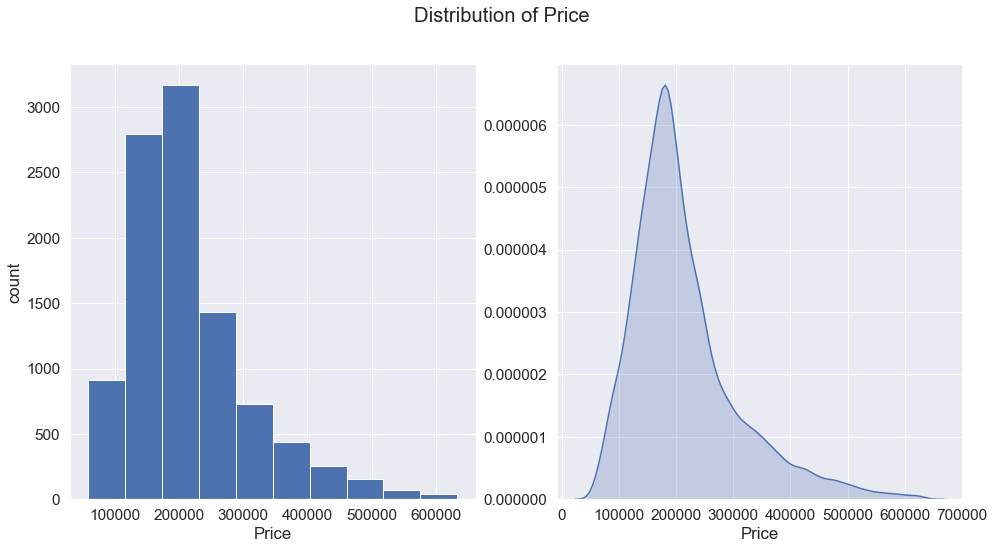

In [329]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

## Проверка разделения

In [330]:
df1=df[df['Price']<300000]
df2=df[df['Price']>300000]

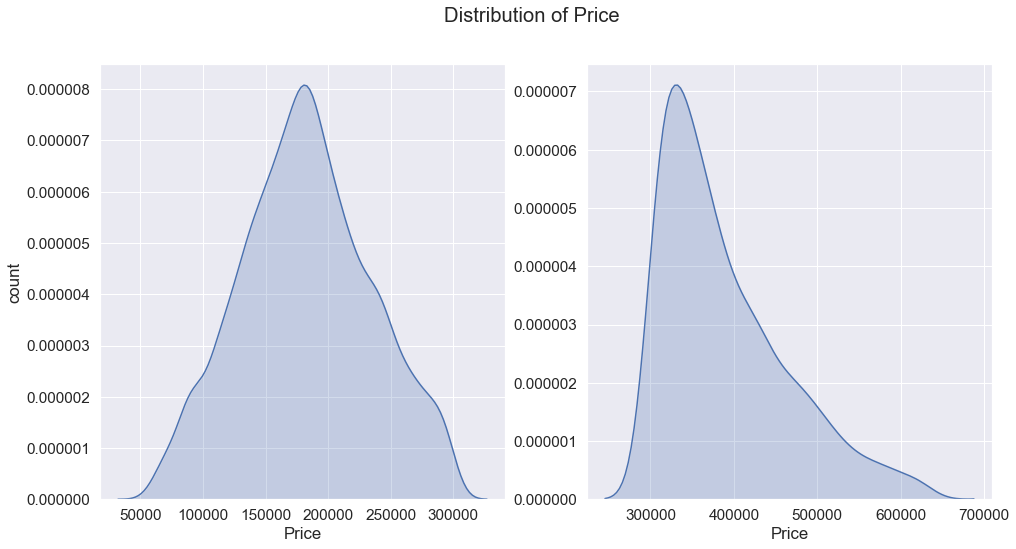

In [331]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
sns.kdeplot(df1['Price'], shade=True, legend=False)
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df2['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [332]:
df2.shape

(1518, 23)

In [333]:
target='Price'

In [334]:
target_mean = round(df1[target].mean(), 2)
target_median = df1[target].median()
target_mode = df1[target].mode()[0]

target_mean, target_median, target_mode

(182789.65, 181648.0932786222, 59174.77802758122)

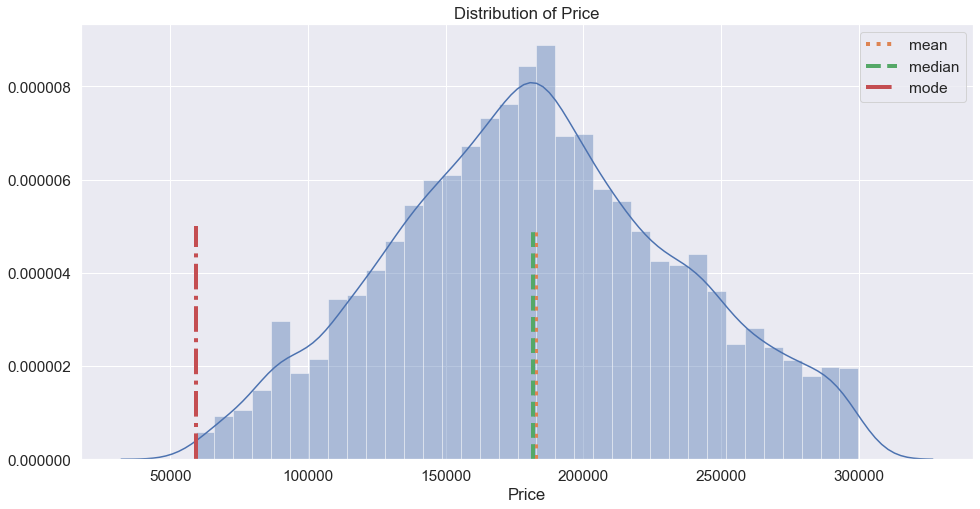

In [335]:
plt.figure(figsize = (16, 8))

sns.distplot(df1[target])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

In [336]:
target_mean = round(df2[target].mean(), 2)
target_median = df2[target].median()
target_mode = df2[target].mode()[0]

target_mean, target_median, target_mode

(389216.71, 367335.4356900237, 300001.92745199165)

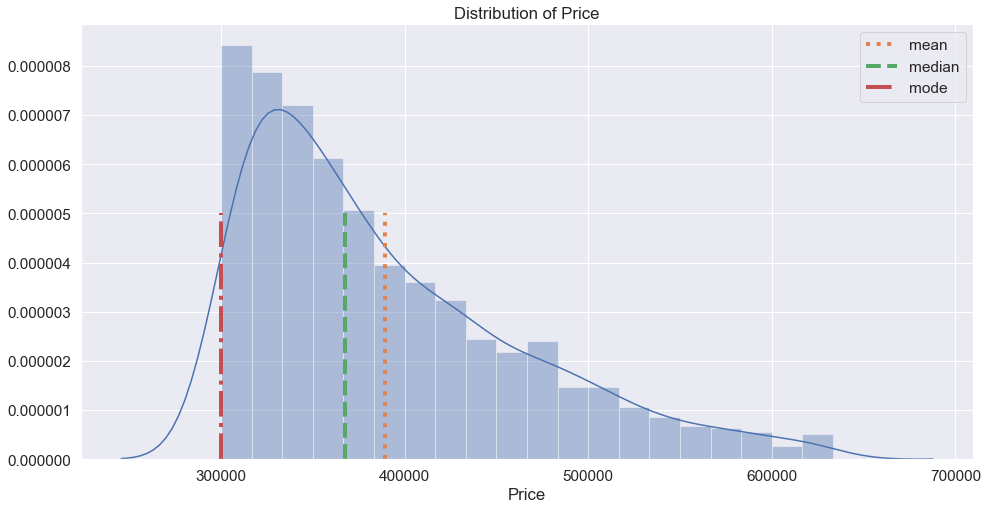

In [337]:
plt.figure(figsize = (16, 8))

sns.distplot(df2[target])

y = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Оценка распредения целевой переменной в разрезе других признаков

In [375]:
df['DistrictId']


0        35
1        41
2        53
3        58
4        99
       ... 
9995     32
9996     18
9997     27
9998     75
9999    128
Name: DistrictId, Length: 9996, dtype: int64

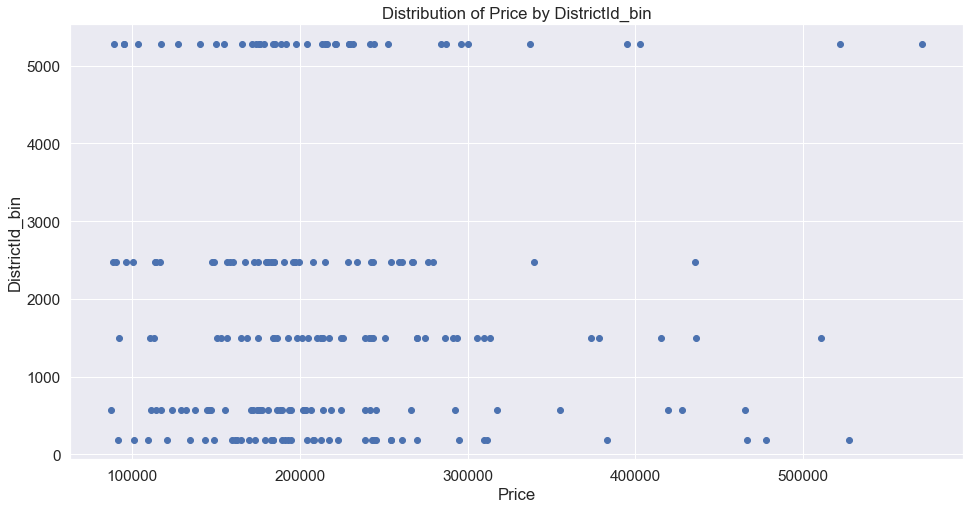

In [376]:
plt.figure(figsize=(16, 8))

plt.scatter(df['Price'], df['DistrictId_bin'])

plt.xlabel('Price')
plt.ylabel('DistrictId_bin')
plt.title('Distribution of Price by DistrictId_bin')
plt.show()

In [377]:
matrix_cor=df.corr()
matrix_cor.style.background_gradient(cmap='coolwarm')
#matrix_cor.loc[matrix_cor['Price']>0.2,'Price']

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictId_bin
Id,1,0.0130417,-0.00679743,-0.00523176,-0.0171833,0.019902,0.00141247,-0.00457207,0.00352019,0.018379,-0.000728141,-0.00205987,-0.00981427,-0.00396709,0.00171292,-0.00891426,0.00988105,-0.00312844,0.00572805,-0.00373242,-0.0719266
DistrictId,0.0130417,1,0.0767465,-0.0284271,-0.0188485,0.0402823,-0.12014,-0.200895,-0.201582,0.0651505,0.24646,0.167537,0.136583,0.304246,0.306128,0.174467,0.265145,0.0934271,0.0274654,0.021039,-0.00815515
Rooms,-0.00679743,0.0767465,1,0.755541,0.279104,0.00472964,-0.00596184,-0.037785,-0.0449663,-0.0315752,0.0783512,0.0726528,0.0144597,0.0429692,0.0642703,0.0544106,0.569647,0.00246607,0.00450069,0.00145823,0.0674364
Square,-0.00523176,-0.0284271,0.755541,1,0.329842,0.00830186,0.116568,0.131202,0.189969,-0.0716382,-0.0783891,-0.0485496,0.0230491,-0.0473585,-0.033585,0.0104333,0.578957,-0.0322408,-0.0307847,0.0573546,0.065179
LifeSquare,-0.0171833,-0.0188485,0.279104,0.329842,1,-0.870112,0.0415514,0.05415,0.0660348,-0.0168045,-0.0301048,-0.0194816,0.022766,-0.00925623,-0.0289215,0.0115635,0.202917,-0.0078647,-0.0106882,-0.0105257,-0.0167206
KitchenSquare,0.019902,0.0402823,0.00472964,0.00830186,-0.870112,1,-0.0114353,-0.00934699,0.0383901,-0.00564111,0.0433572,0.0377809,-0.015233,0.0090083,0.0430809,0.0101273,0.0287225,-0.000260716,0.00752276,0.017339,-0.0735209
Floor,0.00141247,-0.12014,-0.00596184,0.116568,0.0415514,-0.0114353,1,0.58151,0.284417,-0.0159183,-0.04492,-0.0166951,-0.00341628,-0.138719,-0.0658756,0.0234391,0.12878,-0.0496472,-0.0261697,0.0137403,-0.0531389
HouseFloor,-0.00457207,-0.200895,-0.037785,0.131202,0.05415,-0.00934699,0.58151,1,0.448671,-0.0257136,-0.0698923,-0.0286798,-0.0128665,-0.180781,-0.110916,0.0170422,0.112336,-0.0754214,-0.0295516,-0.00229076,-0.0729653
HouseYear,0.00352019,-0.201582,-0.0449663,0.189969,0.0660348,0.0383901,0.284417,0.448671,1,-0.0664953,-0.0480172,0.0135863,-0.0505038,-0.206406,-0.117043,-0.00303627,0.0366122,-0.076794,-0.0480504,0.0590268,-0.0650726
Ecology_1,0.018379,0.0651505,-0.0315752,-0.0716382,-0.0168045,-0.00564111,-0.0159183,-0.0257136,-0.0664953,1,0.0264308,0.00931001,-0.123695,-0.0436226,0.0308245,-0.0764845,-0.0584512,0.110745,0.223409,-0.0797971,-0.145972


In [411]:
target_name = 'Price' #LifeSquare
feature_names=['Rooms','Square','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_2',
               'Social_3','Helthcare_2','Shops_1','Ecology_2_bin','Ecology_3_bin','Shops_2_bin']


In [412]:
df1 = df1[feature_names+[target_name]]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8478 entries, 0 to 9999
Data columns (total 15 columns):
Rooms            8478 non-null float64
Square           8478 non-null float64
KitchenSquare    8478 non-null float64
Floor            8478 non-null int64
HouseFloor       8478 non-null float64
HouseYear        8478 non-null float64
Ecology_1        8478 non-null float64
Social_2         8478 non-null int64
Social_3         8478 non-null int64
Helthcare_2      8478 non-null int64
Shops_1          8478 non-null int64
Ecology_2_bin    8478 non-null int64
Ecology_3_bin    8478 non-null int64
Shops_2_bin      8478 non-null int64
Price            8478 non-null float64
dtypes: float64(7), int64(8)
memory usage: 1.0 MB


In [413]:
feature_names_for_stand=feature_names

In [414]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df1[feature_names_for_stand])

In [415]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.529
MAE:	44894.205
MSE:	4073565464.514


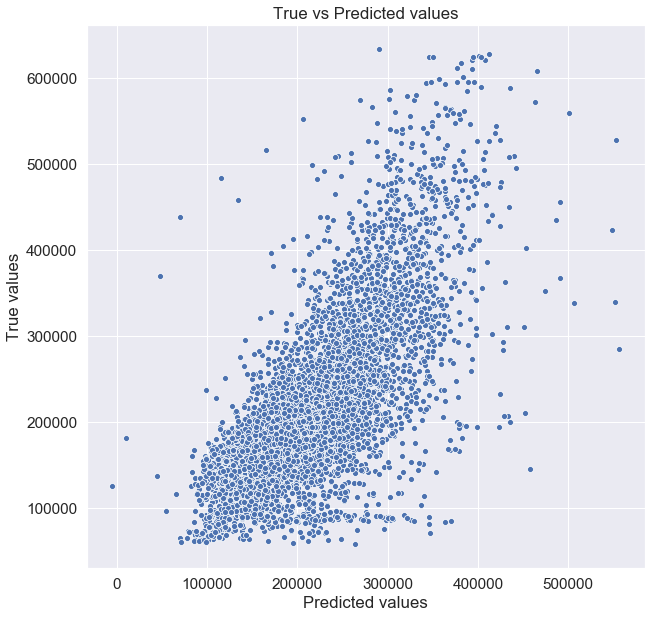

In [416]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.509
MAE:	45726.597
MSE:	4204290234.542


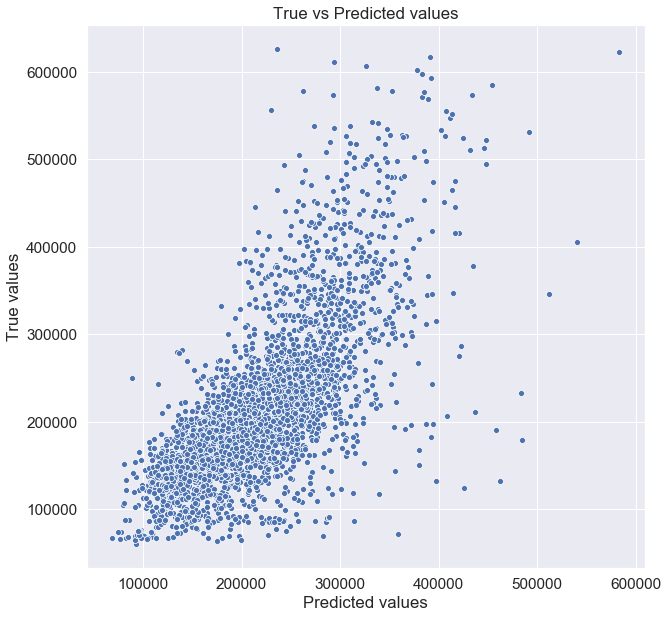

In [417]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Модель RandomForestRegressor

In [418]:
X = df[feature_names]
y = df[target_name]

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [420]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.944
MAE:	12439.332
MSE:	483824739.165


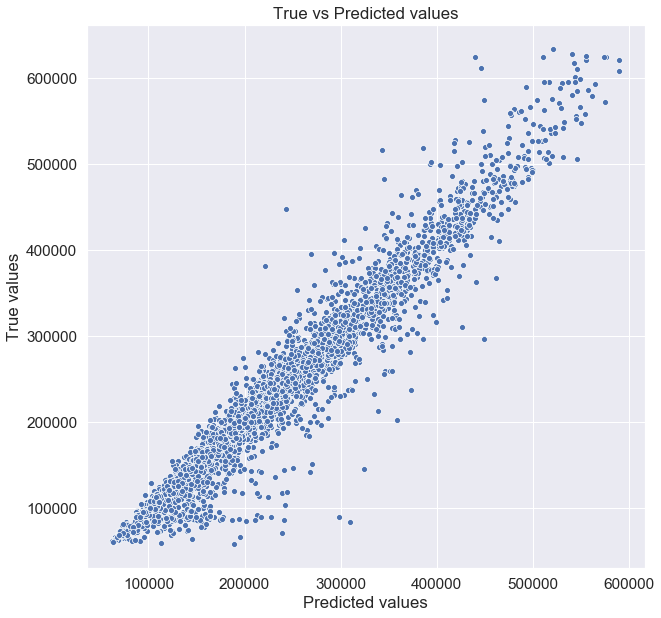

In [421]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.691
MAE:	31194.437
MSE:	2640345765.797


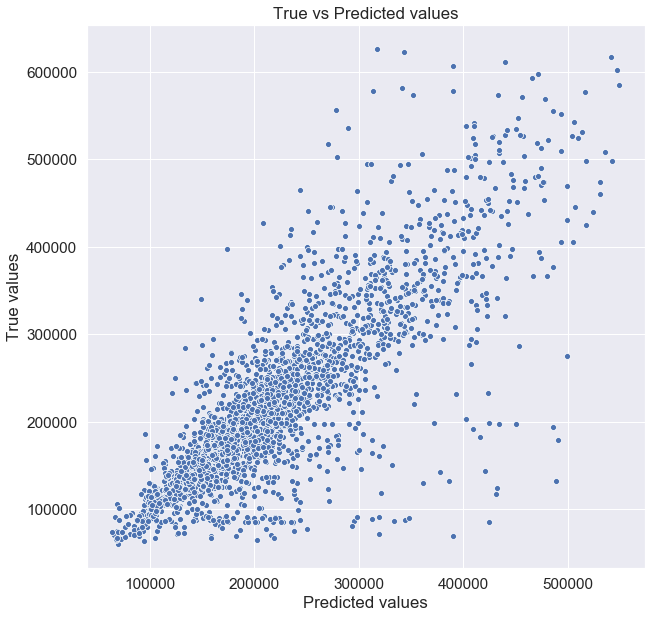

In [422]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)